In [78]:
import numpy as np
from qutip import *
import dask
from dask import delayed
from dask.distributed import Client, LocalCluster
from tqdm import tqdm
from functions_fbq import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

In [66]:
# Crear un clúster local de Dask y un cliente para conectarse a él
cluster = LocalCluster(n_workers=2, threads_per_worker=2)
client = Client(cluster)

c:\Users\Quantro\.conda\envs\parallel\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50014 instead
  warnings.warn(


In [80]:
Ec = 40e9
EDelta = 20e9
El_list = 5 * 1e9 * np.logspace(-2, 1, 20)
r_list = np.linspace(0.05, 0.95, 20)
eigvals = 2
phi_ext = 0

phi_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
n_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
d2E01dphi2_list = np.zeros((len(El_list), len(r_list)))

In [81]:
@delayed
def process_r(El, r):
    eigvals_list, _, matrix_op_sqr_list = eigensystem_and_matrix_elements_sqr_fbq(Ec, El, EDelta, 0, r,100, eigvals)
    phi_matrix_element = matrix_op_sqr_list[0]
    n_matrix_element = matrix_op_sqr_list[1]

    phi_ext_list = np.linspace(0, 0.1, 10)
    eigvals_list = np.array([np.real(eigensystem_and_matrix_elements_sqr_fbq(Ec, El, EDelta, phi_ext_aux, r, N = 100, eigvals = 2)[0][1] - eigensystem_and_matrix_elements_sqr_fbq(Ec, El, EDelta, 0, r, N = 50, eigvals = 2)[0][0]) for phi_ext_aux in phi_ext_list])

    phi_ext_list = np.concatenate([-phi_ext_list[::-1][0:-1], phi_ext_list])
    eigvals_list = np.concatenate([eigvals_list[::-1][0:-1], eigvals_list])

    dE01_dphi = np.gradient(eigvals_list, phi_ext_list, edge_order=1)
    d2E01_dphi2 = np.gradient(dE01_dphi, phi_ext_list, edge_order=1)
    d2E01dphi2 = d2E01_dphi2[len(phi_ext_list) // 2]

    return phi_matrix_element, n_matrix_element, d2E01dphi2


In [82]:
# Utilizar Dask para paralelizar y ejecutar los bucles for anidados
results = []
for i, El in enumerate(El_list):
    for j, r in enumerate(r_list):
        result = dask.delayed(process_r)(El, r)
        results.append(result)


In [83]:
# Calcular y asignar los resultados
computed_results = dask.compute(*results)

# Asignar los resultados a las matrices correspondientes
k = 0

for i, El in enumerate(El_list):
    for j, r in enumerate(r_list):
        phi_matrix_element, n_matrix_element, d2E01dphi2 = computed_results[k]
        phi_matrix_elements_list[i, j] = El * np.abs(phi_matrix_element)
        n_matrix_elements_list[i, j] = 8 * Ec * np.abs(n_matrix_element)
        d2E01dphi2_list[i, j] = np.abs(d2E01dphi2)
        k += 1

In [84]:
client.close()
cluster.close()

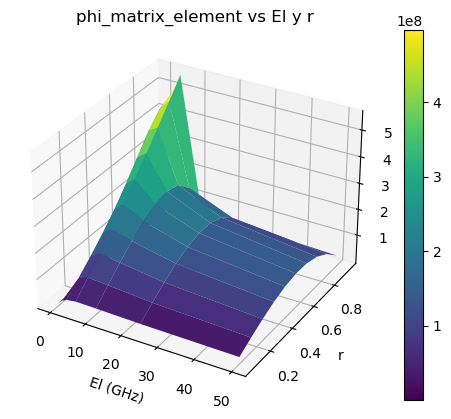

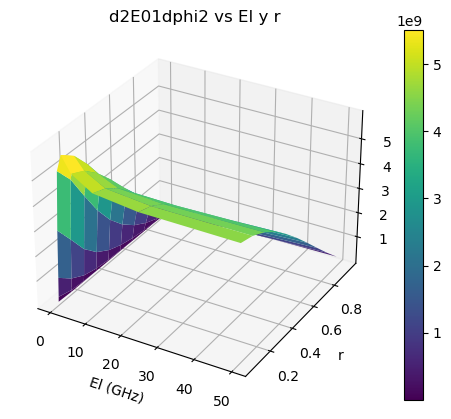

In [91]:
# Preparar los datos para la gráfica
El_mesh, r_mesh = np.meshgrid(El_list, r_list, indexing="ij")

# Graficar phi_matrix_elements_list vs El y r
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d")
surf1 = ax1.plot_surface(El_mesh / 1e9, r_mesh, phi_matrix_elements_list, cmap="viridis")
ax1.set_xlabel("El (GHz)")
ax1.set_ylabel("r")
ax1.set_zlabel("phi_matrix_element")
ax1.set_title("phi_matrix_element vs El y r")
fig1.colorbar(surf1)

# Graficar d2E01dphi2_list vs El y r
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection="3d")
surf2 = ax2.plot_surface(El_mesh / 1e9, r_mesh, d2E01dphi2_list, cmap="viridis")
ax2.set_xlabel("El (GHz)")
ax2.set_ylabel("r")
ax2.set_zlabel("d2E01dphi2")
ax2.set_title("d2E01dphi2 vs El y r")
fig2.colorbar(surf2)

plt.show()


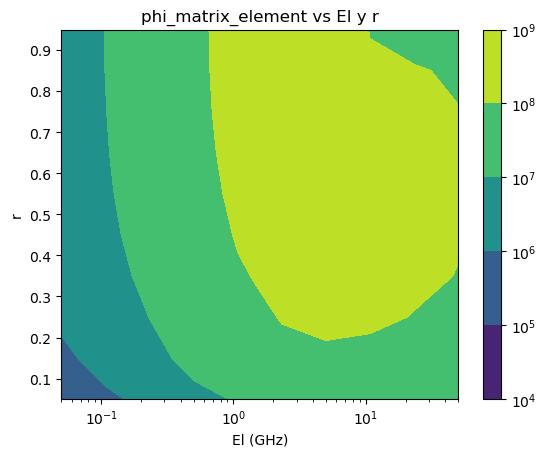

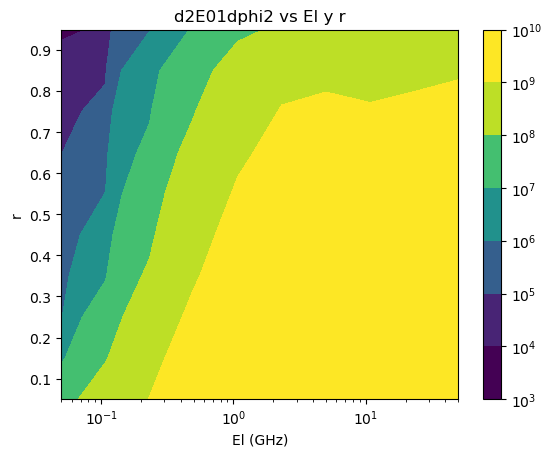

In [94]:
# Escala logarítmica para los colores
norm = colors.LogNorm()
El_mesh, r_mesh = np.meshgrid(El_list, r_list, indexing="ij")
# Graficar phi_matrix_elements_list vs El y r
fig1, ax1 = plt.subplots()
contour1 = ax1.contourf(El_mesh / 1e9, r_mesh, phi_matrix_elements_list, cmap="viridis", norm=norm)
ax1.set_xscale("log")
# ax1.set_yscale("log")
ax1.set_xlabel("El (GHz)")
ax1.set_ylabel("r")
ax1.set_title("phi_matrix_element vs El y r")
fig1.colorbar(contour1)

# Graficar d2E01dphi2_list vs El y r
fig2, ax2 = plt.subplots()
contour2 = ax2.contourf(El_mesh / 1e9, r_mesh, d2E01dphi2_list, cmap="viridis", norm=norm)
ax2.set_xscale("log")
# ax2.set_yscale("log")
ax2.set_xlabel("El (GHz)")
ax2.set_ylabel("r")
ax2.set_title("d2E01dphi2 vs El y r")
fig2.colorbar(contour2)

plt.show()

